## References

* Deep Learning with python, second edition. Chapter 10.

## Install libraries

In [ ]:
!pip3 install -q tensorflow keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/jena_climate_2009_2016.csv

-rw------- 1 root root 43164220 Dec  2 20:08 '/content/drive/My Drive/Colab Notebooks/jena_climate_2009_2016.csv'


## Data

### Download

### Load

Load data:

In [ ]:
import os
fname = os.path.join(r'/content/drive/My Drive/Colab Notebooks/jena_climate_2009_2016.csv')
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In this dataset, 14 different quantities (such as temperature, pressure, humidity, and wind direction) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

`temperature` holds the observed values of the data that we want to predict and `raw_data` holds all the numeric variables, including temperature.

### Plot the data

Plot the temperature over time:

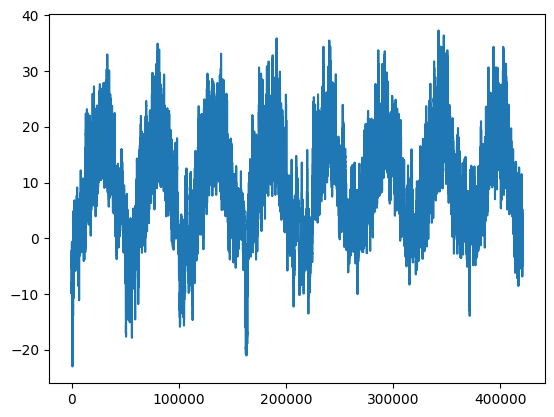

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

First 10 days of temperature data. 24 * 6 = 144 data points per day.

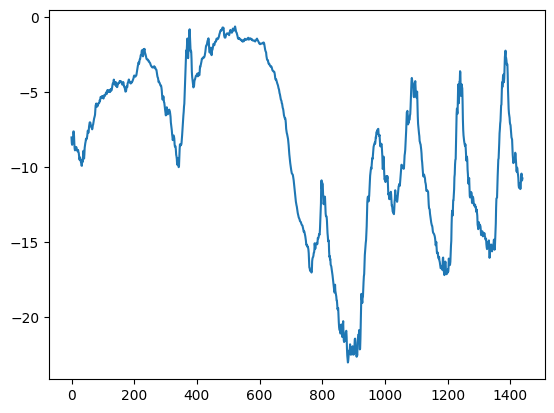

In [ ]:
plt.plot(range(1440), temperature[:1440])

## Task

Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

This notebook contains sample code for:

* Feedforward neural network
* 1D convolution neural network
* 3 variations of recurring neural network

Optimize the three classes of models above to give the best MAE. In addtion, use a transformer to compete in terms of MAE.

This [page](https://keras.io/examples/timeseries/timeseries_classification_transformer/) contains a reference of using a Transformer for time-series data.

The sample code below is a starting point. Your job is to extract the most value out of the models mentioned above. You are free to go beyond what is requested here and try out different models if you like.

Return a `.ipynb` containing the code (one section per model) and start the document with a summary of the models you tried and their respective MAEs in a table.

**Deadline**: 05/12

### Prepare the data

Decide the number of data points that will be assigned to training, validation and test sets.

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


Normalize the data.

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Create `tensorflow.data.Dataset` for training, validation and test splits:

In [ ]:
import keras

sampling_rate = 6
sequence_length = 120 # 5 days sampled once an hour: 5*24 = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

Check the input dimensions:

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Use naive model as baseline:

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## Feedforward neural network

In [ ]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26913 (105.13 KB)
Trainable params: 26913 (105.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 50ms/step - loss: 12.0256 - mae: 2.6906 - val_loss: 10.7113 - val_mae: 2.5768
Epoch 2/10
819/819 [==============================] - 40s 48ms/step - loss: 8.9647 - mae: 2.3515 - val_loss: 11.0008 - val_mae: 2.6116
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 8.2628 - mae: 2.2554 - val_loss: 10.3286 - val_mae: 2.5330
Epoch 4/10
819/819 [==============================] - 38s 47ms/step - loss: 7.8205 - mae: 2.1960 - val_loss: 11.7737 - val_mae: 2.7169
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 7.5290 - mae: 2.1556 - val_loss: 10.6396 - val_mae: 2.5735
Epoch 6/10
819/819 [==============================] - 47s 58ms/step - loss: 7.2912 - mae: 2.1249 - val_loss: 11.4445 - val_mae: 2.6826
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 7.0883 - mae: 2.0935 - val_loss: 10.9756 - val_mae: 2.6203
Epoch 8/10
819/819 [==============================] - 

In [ ]:
del model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten_2 (Flatten)         (None, 1680)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                107584    
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 110209 (430.50 KB)
Trainable params: 110209 (

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 59ms/step - loss: 10.0230 - mae: 2.4298 - val_loss: 11.6847 - val_mae: 2.6800
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 5.4066 - mae: 1.8061 - val_loss: 13.7901 - val_mae: 2.8891
Epoch 3/10
819/819 [==============================] - 39s 48ms/step - loss: 3.9949 - mae: 1.5527 - val_loss: 15.0778 - val_mae: 3.0121
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 3.2420 - mae: 1.3962 - val_loss: 15.4306 - val_mae: 3.0360
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 2.7924 - mae: 1.2945 - val_loss: 15.3756 - val_mae: 3.0572
Epoch 6/10
819/819 [==============================] - 49s 60ms/step - loss: 2.4565 - mae: 1.2159 - val_loss: 16.0142 - val_mae: 3.1173
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 2.2373 - mae: 1.1608 - val_loss: 15.6665 - val_mae: 3.0799
Epoch 8/10
819/819 [==============================] - 

Parece que a performance melhorou levemente ao adicionar mais camadas e aumentar seus números de neurônios. Vamos tentar outras arquiteturas para encontrar melhores alternativas.

In [ ]:
del model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten_4 (Flatten)         (None, 1680)              0         
                                                                 
 dense_13 (Dense)            (None, 16)                26896     
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 27041 (105.63 KB)
Trainable params: 27041 (105.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 58ms/step - loss: 10.7729 - mae: 2.5168 - val_loss: 11.3161 - val_mae: 2.6472
Epoch 2/10
819/819 [==============================] - 48s 59ms/step - loss: 7.5164 - mae: 2.1532 - val_loss: 11.6824 - val_mae: 2.7042
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 6.8652 - mae: 2.0586 - val_loss: 12.4325 - val_mae: 2.7905
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 6.4904 - mae: 2.0031 - val_loss: 11.2849 - val_mae: 2.6434
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 6.1899 - mae: 1.9564 - val_loss: 11.6700 - val_mae: 2.6844
Epoch 6/10
819/819 [==============================] - 40s 48ms/step - loss: 6.0477 - mae: 1.9330 - val_loss: 12.5858 - val_mae: 2.7869
Epoch 7/10
819/819 [==============================] - 40s 49ms/step - loss: 5.9337 - mae: 1.9146 - val_loss: 12.1108 - val_mae: 2.7217
Epoch 8/10
819/819 [==============================] - 

In [ ]:
del model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 flatten_9 (Flatten)         (None, 1680)              0         
                                                                 
 dense_24 (Dense)            (None, 8)                 13448     
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13457 (52.57 KB)
Trainable params: 13457 (52.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 43s 51ms/step - loss: 11.3116 - mae: 2.5874 - val_loss: 10.4665 - val_mae: 2.5552
Epoch 2/10
819/819 [==============================] - 38s 46ms/step - loss: 8.6522 - mae: 2.3153 - val_loss: 10.3061 - val_mae: 2.5361
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 8.2613 - mae: 2.2640 - val_loss: 11.4635 - val_mae: 2.6718
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 8.0738 - mae: 2.2413 - val_loss: 10.1307 - val_mae: 2.5017
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 8.0008 - mae: 2.2311 - val_loss: 10.5752 - val_mae: 2.5658
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 7.8649 - mae: 2.2133 - val_loss: 10.1302 - val_mae: 2.5054
Epoch 7/10
819/819 [==============================] - 38s 46ms/step - loss: 7.7966 - mae: 2.2039 - val_loss: 10.5006 - val_mae: 2.5533
Epoch 8/10
819/819 [==============================] - 

In [ ]:
del model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)


model.compile(optimizer=opt, loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 48ms/step - loss: 10.9692 - mae: 2.4099 - val_loss: 12.0636 - val_mae: 2.7100
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 4.1023 - mae: 1.5620 - val_loss: 12.8011 - val_mae: 2.8144
Epoch 3/10
819/819 [==============================] - 40s 48ms/step - loss: 2.4336 - mae: 1.2088 - val_loss: 14.1815 - val_mae: 2.9354
Epoch 4/10
819/819 [==============================] - 49s 59ms/step - loss: 1.7744 - mae: 1.0359 - val_loss: 13.2820 - val_mae: 2.8598
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 1.4306 - mae: 0.9300 - val_loss: 13.7577 - val_mae: 2.9176
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 1.2038 - mae: 0.8542 - val_loss: 15.5491 - val_mae: 3.1177
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 1.1881 - mae: 0.8436 - val_loss: 14.0280 - val_mae: 2.9340
Epoch 8/10
819/819 [==============================] - 

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)


model.compile(optimizer=opt, loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 42s 49ms/step - loss: 10.7914 - mae: 2.3431 - val_loss: 13.5012 - val_mae: 2.9006
Epoch 2/10
819/819 [==============================] - 38s 47ms/step - loss: 4.0679 - mae: 1.5608 - val_loss: 15.0434 - val_mae: 3.0648
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 2.7607 - mae: 1.2903 - val_loss: 18.8561 - val_mae: 3.4340
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 2.3023 - mae: 1.1792 - val_loss: 15.9227 - val_mae: 3.1506
Epoch 5/10
819/819 [==============================] - 48s 59ms/step - loss: 1.9481 - mae: 1.0840 - val_loss: 16.2292 - val_mae: 3.1816
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 1.7777 - mae: 1.0362 - val_loss: 15.3969 - val_mae: 3.0904
Epoch 7/10
819/819 [==============================] - 38s 46ms/step - loss: 1.6305 - mae: 0.9950 - val_loss: 16.0825 - val_mae: 3.1421
Epoch 8/10
819/819 [==============================] - 

In [ ]:
del model

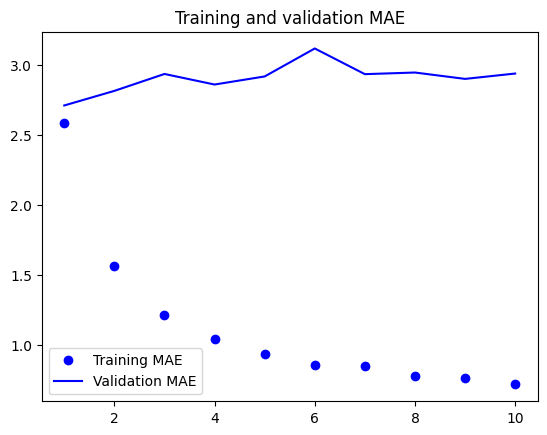

In [ ]:
import matplotlib.pyplot as plt

# loss = history.history["mae"]
# val_loss = history.history["val_mae"]

loss = [2.5874, 1.5620, 1.2088, 1.0359, 0.9300, 0.8542, 0.8436, 0.7727, 0.7605, 0.7141]
val_loss = [2.7100, 2.8144, 2.9354, 2.8598, 2.9176, 3.1177, 2.9340, 2.9457, 2.9001, 2.9384]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Nosso modelo de NN Feedforward com melhor performance foi o com a seguinte arquitetura:
Camada densa de 256 neurônios, ativação ReLU
Camada densa de 64 neurônios, ativação ReLU
Camada densa de 16 neurônios, ativação ReLU
Camada de output, 1 neurônio

## 1D convolution neural network

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 55ms/step - loss: 23.1158 - mae: 3.7265 - val_loss: 14.9453 - val_mae: 3.0820
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 15.5918 - mae: 3.1390 - val_loss: 15.5827 - val_mae: 3.1468
Epoch 3/10
819/819 [==============================] - 50s 60ms/step - loss: 14.3439 - mae: 3.0080 - val_loss: 14.7507 - val_mae: 3.0095
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 13.5191 - mae: 2.9197 - val_loss: 20.8217 - val_mae: 3.6119
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 12.8158 - mae: 2.8411 - val_loss: 14.8799 - val_mae: 3.0423
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 12.2731 - mae: 2.7759 - val_loss: 15.7611 - val_mae: 3.1180
Epoch 7/10
819/819 [==============================] - 49s 59ms/step - loss: 11.8224 - mae: 2.7226 - val_loss: 14.9657 - val_mae: 3.0365
Epoch 8/10
819/819 [============================

In [ ]:
del model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(32, 1, activation="relu")(inputs)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(32, 1, activation="relu")(inputs)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history2 = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 52ms/step - loss: 8.8226 - mae: 2.2586 - val_loss: 12.6331 - val_mae: 2.7680
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 3.5253 - mae: 1.4593 - val_loss: 14.7337 - val_mae: 2.9775
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 2.1270 - mae: 1.1386 - val_loss: 15.9218 - val_mae: 3.0859
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 1.6559 - mae: 1.0066 - val_loss: 14.1818 - val_mae: 2.9226
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 1.4151 - mae: 0.9314 - val_loss: 13.8710 - val_mae: 2.9049
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 1.3047 - mae: 0.8949 - val_loss: 14.0762 - val_mae: 2.9198
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 1.1848 - mae: 0.8531 - val_loss: 14.1133 - val_mae: 2.9411
Epoch 8/10
819/819 [==============================] - 4

In [ ]:
del model

In [ ]:
# arquitetura baseada em https://albertum.medium.com/conv1d-layers-in-time-series-fb7b795bce30

inputs = keras.layers.Input(shape = (sequence_length, raw_data.shape[-1]))
x = inputs
skips = []

dilation_rates = [1, 2, 4]
n_filters = 4
filter_width = 2

for dilation in dilation_rates:

  x = keras.layers.Conv1D(filters = 16,
                             kernel_size = 1,
                             padding = 'same',
                             activation = 'relu')(x)

  x_d = keras.layers.Conv1D(filters = n_filters,
                               kernel_size = filter_width,
                               padding = 'causal',
                               dilation_rate = dilation,
                               activation = keras.activations.swish)(x)

  z = keras.layers.Conv1D(filters = 16,
                             kernel_size = 1,
                             padding = 'same',
                             activation = 'relu')(x_d)

  x = keras.layers.Add()([x, z])

  skips.append(z)

# assemble the skips
out = keras.layers.Add()(skips)
out = keras.layers.Conv1D(filters = 1,
                             kernel_size = 1,
                             padding = 'same')(out)
out = keras.layers.Flatten()(out)
outputs = keras.layers.Dense(1)(out)

model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history3 = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 55ms/step - loss: 18.1548 - mae: 3.2200 - val_loss: 10.1784 - val_mae: 2.4797
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 10.5434 - mae: 2.5492 - val_loss: 9.6194 - val_mae: 2.4043
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 9.8795 - mae: 2.4619 - val_loss: 9.5776 - val_mae: 2.3994
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.5546 - mae: 2.4178 - val_loss: 9.3449 - val_mae: 2.3707
Epoch 5/10
819/819 [==============================] - 44s 54ms/step - loss: 9.2898 - mae: 2.3816 - val_loss: 9.2254 - val_mae: 2.3563
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 9.1277 - mae: 2.3595 - val_loss: 9.2334 - val_mae: 2.3618
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 8.9815 - mae: 2.3410 - val_loss: 9.2787 - val_mae: 2.3722
Epoch 8/10
819/819 [==============================] - 44s 5

In [ ]:
del model

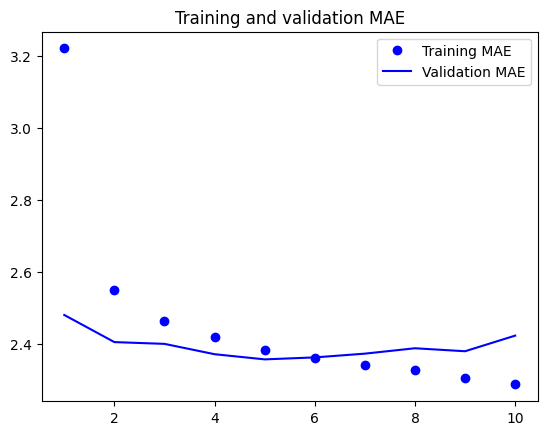

In [ ]:
loss = history3.history["mae"]
val_loss = history3.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Tivemos grande sucesso com essa arquitetura, melhorando consideravelmente a rede 1D Conv original, mas ainda não está melhor que o naive.

## RNN with LSTM cell

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 56s 65ms/step - loss: 39.8405 - mae: 4.5868 - val_loss: 12.3255 - val_mae: 2.6814
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 11.0042 - mae: 2.5885 - val_loss: 9.7638 - val_mae: 2.4275
Epoch 3/10
819/819 [==============================] - 52s 64ms/step - loss: 9.8273 - mae: 2.4485 - val_loss: 9.9432 - val_mae: 2.4497
Epoch 4/10
819/819 [==============================] - 46s 55ms/step - loss: 9.3053 - mae: 2.3837 - val_loss: 10.0023 - val_mae: 2.4597
Epoch 5/10
819/819 [==============================] - 52s 63ms/step - loss: 9.0274 - mae: 2.3464 - val_loss: 9.7619 - val_mae: 2.4346
Epoch 6/10
819/819 [==============================] - 44s 54ms/step - loss: 8.8136 - mae: 2.3197 - val_loss: 10.0888 - val_mae: 2.4704
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 8.6361 - mae: 2.2965 - val_loss: 10.0016 - val_mae: 2.4549
Epoch 8/10
819/819 [==============================] - 44

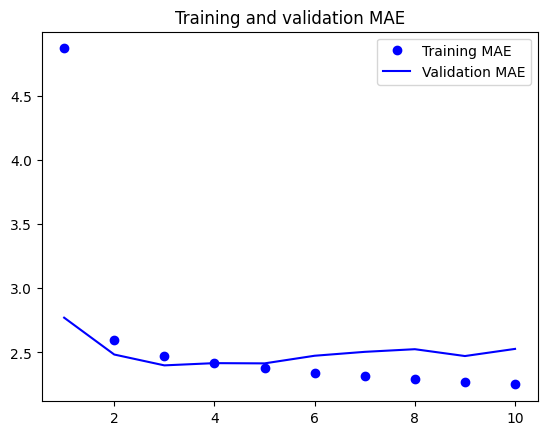

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## RNN with LSTM cell and recurrent dropout

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6016      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 68s 82ms/step - loss: 27.4771 - mae: 3.8642 - val_loss: 9.7172 - val_mae: 2.4380
Epoch 2/50
819/819 [==============================] - 67s 81ms/step - loss: 14.9045 - mae: 3.0006 - val_loss: 9.3520 - val_mae: 2.3765
Epoch 3/50
819/819 [==============================] - 67s 82ms/step - loss: 14.1340 - mae: 2.9132 - val_loss: 9.4616 - val_mae: 2.3848
Epoch 4/50
819/819 [==============================] - 66s 81ms/step - loss: 13.4593 - mae: 2.8447 - val_loss: 9.5603 - val_mae: 2.4069
Epoch 5/50
819/819 [==============================] - 67s 82ms/step - loss: 13.0053 - mae: 2.7883 - val_loss: 9.5383 - val_mae: 2.4052
Epoch 6/50
819/819 [==============================] - 66s 81ms/step - loss: 12.6874 - mae: 2.7527 - val_loss: 9.8109 - val_mae: 2.4397
Epoch 7/50
819/819 [==============================] - 66s 81ms/step - loss: 12.3014 - mae: 2.7161 - val_loss: 10.1385 - val_mae: 2.4824
Epoch 8/50
819/819 [==============================] - 

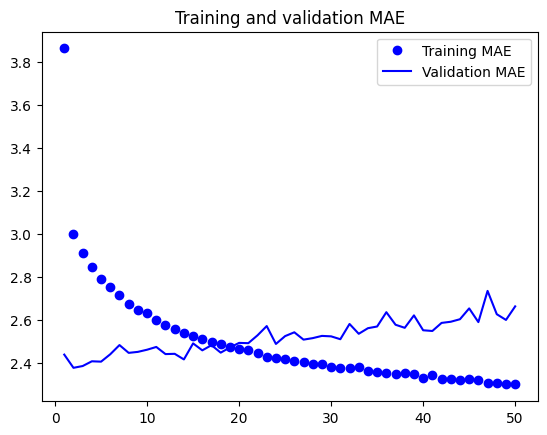

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Stacked RNN layers

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 142s 172ms/step - loss: 26.3065 - mae: 3.7720 - val_loss: 10.4601 - val_mae: 2.5255
Epoch 2/50
819/819 [==============================] - 142s 173ms/step - loss: 13.6321 - mae: 2.8568 - val_loss: 9.8368 - val_mae: 2.4439
Epoch 3/50
819/819 [==============================] - 142s 174ms/step - loss: 12.4769 - mae: 2.7306 - val_loss: 10.0937 - val_mae: 2.4758
Epoch 4/50
819/819 [==============================] - 142s 173ms/step - loss: 11.5680 - mae: 2.6314 - val_loss: 10.2498 - val_mae: 2.4925
Epoch 5/50
819/819 [==============================] - 142s 174ms/step - loss: 10.8748 - mae: 2.5471 - val_loss: 10.1394 - val_mae: 2.5081
Epoch 6/50
819/819 [==============================] - 142s 173ms/step - loss: 10.2750 - mae: 2.4737 - val_loss: 10.0864 - val_mae: 2.4920
Epoch 7/50
819/819 [==============================] - 141s 172ms/step - loss: 9.7846 - mae: 2.4076 - val_loss: 10.6001 - val_mae: 2.5501
Epoch 8/50
819/819 [================